# Python en Finanzas - Trabajo Final


Ejercicio -
Asumamos que trabajamos en el área de finanzas de una empresa y estamos preparando la reunión mensual.

La empresa tiene en la cartera de inversiones un bono que vence dentro de exactamente 8 años con cupón semestral del 5.875% amortizable al vencimiento con VN 100. Nos ofrecen un Tender (oferta de recompra del bono) pero no nos informaron a qué precio se ejecutaría el Tender en caso de aceptar. Nos van a dar esa información en la misma reunión. Además la empresa va a recibir un flujo de dinero. 

Debemos calcular el precio teórico del bono y su duration. Si el precio teórico es menor que el ofertado para entrar en el Tender aceptaremos, de lo contrario nos quedaremos con el bono.


En el caso en que sea conveniente aceptar el Tender, con el dinero recibido por la venta del bono se quiere invertir en una cartera compuesta por los siguientes activos: S&P 500 (^GSPC), NASDAQ 100 (^NDX), Russell 2000 Value (^RUT), iShares MSCI Emerging Markets ETF (EEM), Vanguard Total International Bond Index Fund ETF Shares (BNDX) con un nivel de volatilidad de 11% y las siguientes restricciones:

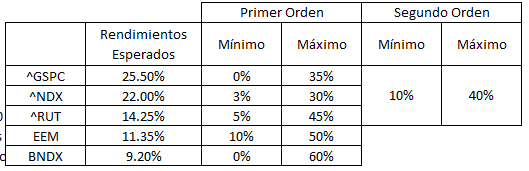

Deseamos conocer los pesos correspondientes a cada índice /ETF que conforman el portfolio óptimo. Calcular los mismo y graficar los retornos de los índices y los histogramas.

En el caso en que no convenga aceptar el Tender, con el ingreso de dinero se desean comprar tres acciones entre cuatro opciones disponibles: The Walt Disney Company (DIS) , AT&T (T), Pfizer Inc. (PFE), Walmart Inc (WMT). Calcular el ratio de Treynor considerando para el cálculo del beta el modelo CAPM y teniendo en cuenta sólo éste ratio recomendar qué acciones comprar. Realizar los gráficos de los retornos y los histogramas de los mismos. Para las dos acciones seleccionadas calcular el Sharpe Ratio.


Objetivo: Armar una función en donde ingresemos el precio del Tender y nos de como resultado:
los pesos del portfolio óptimo en caso de que sea conveniente vender el bono, junto a los gráficos de retornos y los histogramas de los índices/ETF; de lo contrario, las acciones que debemos comprar con el ingreso de dinero, el gráfico de retornos y el histograma y el sharpe ratio de las tres acciones en caso de que no sea conveniente aceptar en el Tender.

Datos necesarios para realizar los cáculos:

Tasa de descuento= 4.5% anual.

Para el cálculo del portfolio óptimo y para el cálculo de los ratios tomar datos diarios desde el 01-09-2018 al 01-09-2021. 

Tasa libre de riesgo constante = 3.15% anual




Pseudocódigo: Pensar la estructura antes de comenzar el código.

In [4]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import plotly.express as px
from scipy.optimize import minimize

# Función para calcular el precio teórico del bono y su duración
def calcular_precio_duration_bono(tasa_cupon, valor_nominal, años_vencimiento, tasa_descuento, frecuencia=2):
    pago_cupon = valor_nominal * (tasa_cupon / frecuencia)
    periodos = años_vencimiento * frecuencia
    factor_descuento = 1 / ((1 + tasa_descuento / frecuencia) ** periodos)

    precio_bono = sum([pago_cupon * factor_descuento for _ in range(periodos)]) + (valor_nominal * factor_descuento)
    duration_bono = sum([(i + 1) * (pago_cupon * factor_descuento) for i in range(periodos)]) / precio_bono

    return precio_bono, duration_bono

# Función para calcular el portfolio óptimo (pesos) usando el modelo de Markowitz
def calcular_portfolio_optimo(returns):
    def Objetivo(w):
     retornos_eperados=np.array([0.255,0.22,0.1425,0.1125,0.0920])
     w=np.array(w)
     return -(retornos_eperados@w)
    def Restriccion1(w):
     sum_sq=1
     for i in range(len(w)):
         sum_sq -= w[i]
     return sum_sq
    def Restriccion2(w):
     sigma_p=np.sqrt(np.dot(w,np.dot(cov_matrix,w))*252)
     sigma_obj=0.11
     return float(sigma_p-sigma_obj)
    def Restriccion3(w): #MAL, corregir Restriccion3
     return w[0]+w[1]-0.18 

    cov_matrix = returns.cov()

    #Restriccion de igualdad
    rest1={'type':'eq', 'fun':Restriccion1}
    rest2={'type':'eq', 'fun':Restriccion2}
    rest3={'type':'ineq', 'fun':Restriccion3}
    restricciones=[rest1,rest2,rest3]
    #Maximos y Minimos deseados
    b1=(0.0,0.35)
    b2=(0.03,0.30)
    b3=(0.05,0.45)
    b4=(0.10,0.50)
    b5=(0.00,0.60)
    bandas=(b1,b2,b3,b4,b5)
    #Punto Inicial
    w0=[0.0,0.0,0.0,0.0,0.0]
    solucion=minimize(Objetivo,w0,method= 'SLSQP', bounds= bandas, constraints= restricciones)

    Retorno_Port_opt=-1*solucion.fun
    Weight_Port_opt=solucion.x
    #print(solucion)
    #print(Retorno_Port_opt)
    #print(Weight_Port_opt)
    return Weight_Port_opt


# Función para calcular el ratio de Treynor
def calcular_ratio_treynor(returns, tasa_libre_riesgo, beta):
    retornos_exceso = returns - tasa_libre_riesgo
    ratio_treynor = retornos_exceso.mean() / beta
    return ratio_treynor

# Función para calcular el Sharpe Ratio
def calcular_ratio_sharpe(returns, tasa_libre_riesgo):
    retornos_exceso = returns - tasa_libre_riesgo
    ratio_sharpe = retornos_exceso.mean() / retornos_exceso.std()
    return ratio_sharpe

# Función para graficar los retornos de los índices y ETF
def graficar_retornos(returns, titulo):
    fig = px.line(returns, x=returns.index, y=returns.columns, title=titulo)
    fig.update_xaxes(title_text='Fecha')
    fig.update_yaxes(title_text='Retorno diario')
    fig.show()

# Función para graficar histogramas de los retornos
def graficar_histogramas(returns, titulo):
    fig = px.histogram(returns, nbins=30, title=titulo)
    fig.update_xaxes(title_text='Retorno diario')
    fig.update_yaxes(title_text='Frecuencia')
    fig.show()

# Función principal que resuelve el ejercicio
def decision_tender(precio_tender):
    # Datos de bono
    tasa_cupon = 0.05875
    valor_nominal = 100
    años_vencimiento = 8
    tasa_descuento = 0.045

    # Calcular el precio teórico del bono y su duración
    precio_bono, duration_bono = calcular_precio_duration_bono(tasa_cupon, valor_nominal, años_vencimiento, tasa_descuento)
    print(f"Precio teórico del bono: {precio_bono}")
    print(f"Duración del bono: {duration_bono}")

    # Comparar precio teórico con precio del Tender para tomar la decisión
    if precio_bono < precio_tender:
        print("Conveniente aceptar el Tender.")
        # Datos para el portfolio óptimo
        activos = ['^GSPC', '^NDX', '^RUT', 'EEM', 'BNDX']
        fecha_inicio = '2018-09-01'
        fecha_fin = '2021-09-01'
        tasa_libre_riesgo = 0.0315 / 252  # Tasa libre de riesgo diaria

        # Descargar datos históricos de los activos
        datos = yf.download(activos, start=fecha_inicio, end=fecha_fin)['Adj Close']
        retornos = datos.pct_change().dropna()
        #print("Estoy OK")

        # Calcular el portfolio óptimo
        pesos_optimos = calcular_portfolio_optimo(retornos)
        portfolio_optimo = pd.DataFrame({'Activo': activos, 'Peso': pesos_optimos})
        print("Pesos del portfolio óptimo:")
        print(portfolio_optimo)

        # Graficar los retornos y histogramas de los índices/ETF
        graficar_retornos(retornos, "Retornos diarios de los índices/ETF")
        graficar_histogramas(retornos, "Histogramas de los retornos de los índices/ETF")
    else:
        print("No conviene aceptar el Tender.")
        # Datos para las acciones
        tickers = ['DIS', 'T', 'PFE', 'WMT','^GSPC']
        fecha_inicio = '2018-09-01'
        fecha_fin = '2021-09-01'
        tasa_libre_riesgo = 0.0315 / 252  # Tasa libre de riesgo diaria

        # Descargar datos históricos de las acciones
        datos = yf.download(tickers, start=fecha_inicio, end=fecha_fin)['Adj Close']
        retornos = datos.pct_change().dropna()

        # Calcular el ratio de Treynor para cada acción
        beta = retornos.apply(lambda col: np.cov(col, retornos['^GSPC'])[0, 1] / np.var(retornos['^GSPC']), axis=0)
        retornos.drop('^GSPC', axis=1, inplace=True)
        ratios_treynor = calcular_ratio_treynor(retornos, tasa_libre_riesgo, beta)

        # Recomendar acciones con mayores ratios de Treynor
        acciones_seleccionadas = ratios_treynor.nlargest(3).index
        print("Acciones recomendadas para comprar:")
        print(acciones_seleccionadas)

        # Calcular el Sharpe Ratio para las acciones seleccionadas
        ratios_sharpe = calcular_ratio_sharpe(retornos[acciones_seleccionadas], tasa_libre_riesgo)
        print("Ratios Sharpe de las acciones:")
        print(ratios_sharpe)

        # Graficar los retornos y histogramas de las acciones seleccionadas
        graficar_retornos(retornos[acciones_seleccionadas], "Retornos diarios de las acciones")
        graficar_histogramas(retornos[acciones_seleccionadas], "Histogramas de los retornos de las acciones")

# Ejemplo de uso: ingresar el precio del Tender y obtener los resultados
precio_tender = 105
decision_tender(precio_tender)

Precio teórico del bono: 102.96847195228844
Duración del bono: 2.7176870748299327
Es conveniente aceptar el Tender.
[*********************100%***********************]  5 of 5 completed
Toy OK
Pesos del portfolio óptimo:
  Activo          Peso
0  ^GSPC  3.500000e-01
1   ^NDX  1.878506e-01
2   ^RUT  3.052707e-01
3    EEM  1.000000e-01
4   BNDX  2.585247e-18


c:\Users\Temp\anaconda3\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning:

Values in x were outside bounds during a minimize step, clipping to bounds

